## Tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#dataset
X,y = load_digits(return_X_y=True)

#scores = cross_validate(model, X=X, y=y, cv=kf, n_jobs=-1, random)
def get_cv_score(model, X=X, y=y,cv=5, scoring="accuracy",seed=42):
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    return cross_val_score(model, X, y, cv=kf, n_jobs=1, scoring= scoring).mean()

## [hyperopt](https://github.com/hyperopt/hyperopt), [解説](https://qiita.com/kenchin110100/items/ac3edb480d789481f134)

In [3]:
from hyperopt import hp, tpe, Trials, fmin, space_eval
from sklearn.svm import SVC

# iterationする回数
max_evals = 5
seed = 1
#porams
SVC_parameters = {
    'C': hp.uniform('C', 0, 2),
    'gamma': hp.loguniform('gamma', -8, 2),
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid'])    
}

#objective functions
def objective(args):
    # モデルのインスタンス化
    classifier = SVC(**args)
    #minimize
    return -1*get_cv_score(model=classifier)

# 試行の過程を記録するインスタンス
trials = Trials()
best = fmin(
    # 最小化する値を定義した関数
    objective,
    # 探索するパラメータのdictもしくはlist
    SVC_parameters,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    # 試行の過程を出力
    verbose=1,
    rstate = np.random.RandomState(seed),
)

#探索過程
"""
for item in trials.trials:
    vals = item['misc']['vals']
    result = item['result']
    print('vals:', vals, 'result:', result)
"""    

#result
best_params = space_eval(SVC_parameters, best)
print("Best Params",best_params)
print("Best Score", -objective(best_params))

100%|██████████| 5/5 [00:08<00:00,  1.99s/it, best loss: -0.9877412874488719] 
Best Params {'C': 0.7537837523477133, 'gamma': 0.0006214328599710896, 'kernel': 'rbf'}
Best Score 0.9877412874488719


## [Optuna](https://research.preferred.jp/2018/12/optuna-release/), [解説](https://blog.amedama.jp/entry/2018/12/06/015217)

### basic flow

In [4]:
import optuna
from functools import partial

In [5]:
# iterationする回数
max_evals = 5
seed = 42

def objective(X, y, trial):
    """最小化する目的関数"""
    params = {
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
        'C': trial.suggest_uniform('C', 0, 2),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 2),
    }
    # モデルを作る
    clf = SVC(**params)
    return  - get_cv_score(clf)

f = partial(objective, X, y)
# 最適化のセッションを作る
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=seed))
# 10 回試行する
study.optimize(f, n_trials=max_evals, )

# 最適化したパラメータを出力する
print("Best Params",study.best_params)
print("Best Score", -study.best_value)

[I 2019-06-19 18:29:42,619] Finished trial#0 resulted in value: -0.13916013531063504. Current best value is -0.13916013531063504 with parameters: {'kernel': 'rbf', 'C': 1.5930859737204657, 'gamma': 3.33194399478954e-07}.
[I 2019-06-19 18:29:44,797] Finished trial#1 resulted in value: -0.13916013531063504. Current best value is -0.13916013531063504 with parameters: {'kernel': 'rbf', 'C': 1.5930859737204657, 'gamma': 3.33194399478954e-07}.
[I 2019-06-19 18:29:46,553] Finished trial#2 resulted in value: -0.921502608269878. Current best value is -0.921502608269878 with parameters: {'kernel': 'rbf', 'C': 0.19994983163600577, 'gamma': 6.489912293826584e-05}.
[I 2019-06-19 18:29:49,009] Finished trial#3 resulted in value: -0.9015722281957756. Current best value is -0.921502608269878 with parameters: {'kernel': 'rbf', 'C': 0.19994983163600577, 'gamma': 6.489912293826584e-05}.
[I 2019-06-19 18:29:51,505] Finished trial#4 resulted in value: -0.11074787904322556. Current best value is -0.92150260

Best Params {'kernel': 'rbf', 'C': 0.19994983163600577, 'gamma': 6.489912293826584e-05}
Best Score 0.921502608269878


### multi models

In [6]:
from sklearn.svm import SVC
from tpot import TPOTClassifier
from pygam import LogisticGAM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier#, AdaBoostClassifier

def objective(X, y, trial):
    """最小化する目的関数"""

    # 使う分類器は SVM or RF
    classifier = trial.suggest_categorical('classifier', ['XGBClassifier', "LGBMClassifier", "MLPClassifier", "TPOTClassifier","SVC",  "KNeighborsClassifier", "RandomForest","RidgeClassifier"]) # "CatBoostClassifier"
    # 選ばれた分類器で分岐する
    if classifier == 'XGBClassifier':
        # XGBoost のとき
        params = { 
            "max_depth": trial.suggest_int('XGBClassifier__max_depth', 1, 10),
            "colsample_bytree" : trial.suggest_uniform('XGBClassifier__colsample_bytree', 0.5, 1),
            "subsample" : trial.suggest_uniform('XGBClassifier__subsample', 0.5, 1),
            'n_estimators' : trial.suggest_int('XGBClassifier__n_estimators', 10, 300),
            "learning_rate" : trial.suggest_uniform('XGBClassifier__learning_rate', 0.01, 0.1),        
        }     
        model = XGBClassifier(**params)
   
    elif classifier == "LGBMClassifier":
        # LGBM のとき
        params = { 
            "max_depth": trial.suggest_int('LGBMClassifier__max_depth', 1, 10),
            "colsample_bytree" : trial.suggest_uniform('LGBMClassifier__colsample_bytree', 0.5, 1),
            "subsample" : trial.suggest_uniform('LGBMClassifier__subsample', 0.5, 1),
            'n_estimators' : trial.suggest_int('LGBMClassifier__n_estimators', 10, 300),
            "learning_rate" : trial.suggest_uniform('LGBMClassifier__learning_rate', 0.01, 0.1),        
        }     
        model = LGBMClassifier(**params)
        
    elif classifier == "CatBoostClassifier":
        params = {         
            "learning_rate" : trial.suggest_uniform('CatBoostClassifier__learning_rate', 0.01, 0.1),
            "depth": trial.suggest_int('CatBoostClassifier__depth', 1, 10) ,           
        }
        model = CatBoostClassifier(**params)
        
    elif classifier == "MLPClassifier":
        params = {
            "learning_rate" : trial.suggest_categorical('MLPClassifier__learning_rate', ["constant", "invscaling", "adaptive"]),       
            "hidden_layer_sizes" : trial.suggest_int('MLPClassifier__hidden_layer_size', 10, 1024),
        }
        model = MLPClassifier(**params)
        
    elif classifier == "TPOTClassifier": 
        params = {
            'generations' : trial.suggest_int('TPOTClassifier__generations', 10, 200),        
            'population_size' : trial.suggest_int('TPOTClassifier__population_size', 10, 20),       
        }
        model = TPOTClassifier(**params)
    
    elif classifier == "SVC":
        params = {
            'kernel': trial.suggest_categorical('SVC__kernel', ['rbf', 'sigmoid']),
            'C': trial.suggest_uniform('SVC__C', 0, 2),
            'gamma': trial.suggest_loguniform('SVC__gamma', 1e-8, 2),
        }
        # モデルを作る
        model = SVC(**params)

    elif classifier == "KNeighborsClassifier":
        params = {
            'n_neighbors': trial.suggest_int('KNeighborsClassifier__n_neighbors', 1,20),
        }   
        model = KNeighborsClassifier(**params)
            
    elif classifier == "RandomForest":
        params = {
            "max_depth": trial.suggest_int('RandomForest__max_depth', 1, 10),
            'n_estimators' : trial.suggest_int('RandomForest__n_estimators', 10, 300), 
        }
        model = RandomForestClassifier(**params)
        
    elif classifier == "RidgeClassifier":
        params = {
            'alpha': trial.suggest_uniform('RidgeClassifier__alpha', 1e-8, 10),
        }           
        model = RidgeClassifier(**params)
    return  - get_cv_score(model)        
    
def main():
    dataset = datasets.load_breast_cancer()
    X, y = dataset.data, dataset.target
    f = partial(objective, X, y)
    study = optuna.create_study()
    study.optimize(f, n_trials=100)
    print('params:', study.best_params)

max_evals = 5
seed = 42
f = partial(objective, X, y)
# 最適化のセッションを作る
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=seed))
# 10 回試行する
study.optimize(f, n_trials=max_evals, )
# 最適化したパラメータを出力する
print("Best Params",study.best_params)
print("Best Score", -study.best_value)

[I 2019-06-19 18:30:00,175] Finished trial#0 resulted in value: -0.9204470160431564. Current best value is -0.9204470160431564 with parameters: {'classifier': 'RandomForest', 'RandomForest__max_depth': 4, 'RandomForest__n_estimators': 280}.
[I 2019-06-19 18:30:06,048] Finished trial#1 resulted in value: -0.9737908942649313. Current best value is -0.9737908942649313 with parameters: {'classifier': 'MLPClassifier', 'MLPClassifier__learning_rate': 'constant', 'MLPClassifier__hidden_layer_size': 30}.
[I 2019-06-19 18:30:09,430] Finished trial#2 resulted in value: -0.9766169879757405. Current best value is -0.9766169879757405 with parameters: {'classifier': 'RandomForest', 'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 224}.
[I 2019-06-19 18:30:15,859] Finished trial#3 resulted in value: -0.9743606723179041. Current best value is -0.9766169879757405 with parameters: {'classifier': 'RandomForest', 'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 224}.
[I 2019-06-19 

Best Params {'classifier': 'RandomForest', 'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 224}
Best Score 0.9766169879757405


## CMA-ES

### 1. regression

In [7]:
import cma
from sklearn.datasets import load_boston
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

X,y = load_boston(return_X_y=True)
#np.random.seed(0)
w_shape = y.T.dot(X).shape
w_dim = 1 + np.prod(w_shape)

def objective(w, X=X, y=y):
    A = np.asarray(w[1:].reshape(w_shape))
    b = np.asarray(w[0])
    y_pred = A.dot(X.T) + b
    return mean_squared_error(y.T, y_pred)

es = cma.CMAEvolutionStrategy(w_dim * [0.5], 1,  {'seed':10})
es.optimize(objective)
res = es.result_pretty()  # pretty print result
w = res.xbest
A = np.asarray(w[1:].reshape(w_shape))
b = np.asarray(w[0])

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 14 (seed=10, Wed Jun 19 18:30:18 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.367199796243944e+05 1.0e+00 9.13e-01  9e-01  9e-01 0:00.0
    2     22 3.959981497407284e+04 1.1e+00 8.76e-01  9e-01  9e-01 0:00.0
    3     33 1.657591486898572e+04 1.2e+00 8.34e-01  8e-01  8e-01 0:00.0
  100   1100 1.628795255651946e+02 2.1e+01 9.50e-02  2e-02  1e-01 0:00.9
  200   2200 2.455499650247470e+01 1.2e+02 3.96e-02  3e-03  7e-02 0:01.6
  300   3300 2.392460992638819e+01 3.7e+02 4.88e-03  2e-04  1e-02 0:02.3
  400   4400 2.369923212534815e+01 3.1e+03 3.31e-02  6e-04  2e-01 0:02.9
  500   5500 2.283731691140957e+01 9.9e+03 5.33e-02  6e-04  8e-01 0:03.5
  600   6600 2.190061955675574e+01 1.4e+04 4.02e-02  3e-04  5e-01 0:04.2
  700   7700 2.189483125676570e+01 1.8e+04 1.86e-04  9e-07  2e-03 0:04.8
  800   8800 2.189483118172932e+01 1.7e+04 6.06e-07  2e-09  3e-06 0:05.3
  822   9042 2.189483118172921e+01 1.

In [8]:
#AX + b, A,b
from IPython.display import clear_output
def CMAES_regression(X,y, seed=42):
    w_shape = y.T.dot(X).shape
    w_dim = 1 + np.prod(w_shape)

    def objective(w, X=X, y=y):
        A = np.asarray(w[1:].reshape(w_shape))
        b = np.asarray(w[0])
        y_pred = A.dot(X.T) + b
        return mean_squared_error(y.T, y_pred)

    es = cma.CMAEvolutionStrategy(w_dim * [0.], 1,  {'seed':seed})
    es.optimize(objective)
    res = es.result_pretty()  # pretty print result
    w = res.xbest
    A = np.asarray(w[1:].reshape(w_shape))
    b = np.asarray(w[0])
    return A,b

cv = 5
seed = 1
#kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
kf = ShuffleSplit(n_splits=cv, random_state=seed)
cv_scores = []
for train_index, test_index in kf.split(X, y):
    #train data
    X_train = X[train_index]
    y_train = y[train_index]
    #test data
    X_test= X[test_index]
    y_test = y[test_index]    
        
    A,b = CMAES_regression(X_train, y_train)
    y_test_pred = A.dot(X_test.T) + b
    cv_scores.append(mean_squared_error(y_test.T, y_test_pred))
    clear_output()
print(np.mean(cv_scores))

18.41948725004369


### 2. parameter tuning

In [9]:
X,y = load_digits(return_X_y=True)
n_params = 1 + 1 + 3

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps)

def objective(w, X=X, y=y):
    C = sigmoid(w[0])*2
    gamma =  sigmoid(w[1])*2
    kernel = ['rbf', 'poly', 'sigmoid'][np.argmax(softmax(w[2:]))]
    model = SVC(C=C, gamma=gamma, kernel=kernel)
    return -get_cv_score(model=model)

es = cma.CMAEvolutionStrategy(n_params * [0], 1,  {'seed':seed})
es.optimize(objective)
res = es.result_pretty()  # pretty print result
w = res.xbest

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1, Wed Jun 19 18:31:22 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -9.855004413110174e-01 1.0e+00 1.02e+00  1e+00  1e+00 0:13.1
    2     16 -9.855004413110174e-01 1.4e+00 1.10e+00  1e+00  1e+00 0:17.8
    3     24 -9.855004413110174e-01 1.6e+00 1.06e+00  9e-01  1e+00 0:26.2
    4     32 -9.855004413110174e-01 1.7e+00 1.09e+00  9e-01  1e+00 0:39.3
    5     40 -9.855004413110174e-01 1.8e+00 1.14e+00  1e+00  1e+00 0:48.8
    6     48 -9.855004413110174e-01 1.8e+00 1.17e+00  1e+00  1e+00 0:51.6
termination on tolfun=1e-11
final/bestever f-value = -9.855004e-01 -9.855004e-01
incumbent solution: [-1.6023243194633379, 0.5988471148164749, -1.0306817573541693, 1.8462252899616074, -1.4422614848182698]
std deviation: [1.2998367844641086, 1.2475626235357211, 0.9751973686945885, 1.177765719857353, 0.9911435753354184]


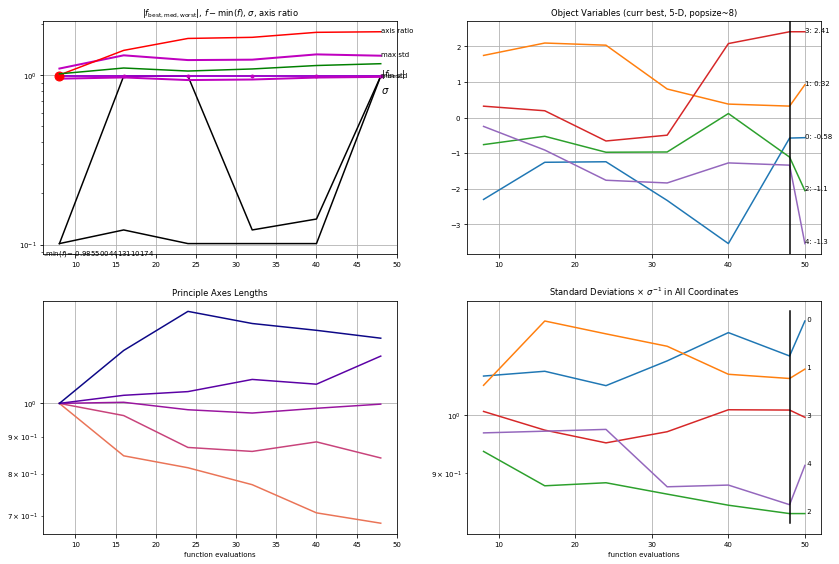

In [10]:
from IPython.core.pylabtools import figsize
figsize(12,8)
cma.plot()